In [186]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline       import make_pipeline
from imblearn.over_sampling  import SMOTE
from sklearn.preprocessing   import StandardScaler
from sklearn.tree            import DecisionTreeClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from sklearn.metrics         import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold
from statistics              import mode
from category_encoders       import TargetEncoder
from sklearn.decomposition   import PCA
from sklearn.pipeline        import Pipeline
from sklearn.ensemble        import RandomForestClassifier, VotingClassifier
from sklearn.linear_model    import LogisticRegression, RidgeClassifier
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier

warnings.filterwarnings("ignore") 

In [326]:
train = pd.read_csv('train_ml2_2021.csv')
test = pd.read_csv('test0.csv')

In [183]:
train.tail()

,problem_id,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v969,v970,v971,v972,v973,v974,v975,v976,v977,target
8297,20,0.91,0.76,0.45,0.81,0.99,0.20,0.36,0.28,0.02,...,0.75,0.92,0.86,0.84,0.86,0.52,0.04,0.77,0.68,0
8298,20,0.31,0.93,0.45,0.61,0.99,0.09,0.73,0.25,0.56,...,0.36,0.93,0.61,0.65,0.65,0.31,0.06,0.89,0.11,0
8299,20,0.92,0.82,0.52,0.61,0.94,0.67,0.65,0.34,0.25,...,0.80,0.74,0.94,0.76,0.61,0.72,0.14,0.11,0.91,0
8300,20,0.93,0.85,0.51,0.64,0.95,0.76,0.76,0.36,0.07,...,0.33,0.92,0.24,0.89,0.84,0.54,0.13,0.91,0.95,0
8301,20,0.87,0.14,0.52,0.64,0.03,0.94,0.45,0.50,0.12,...,0.46,0.83,0.72,0.78,0.75,0.71,0.38,0.19,0.91,1


## EDA

In [3]:
train.shape

(8302, 980)

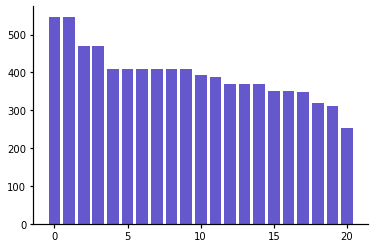

In [180]:
plt.rcParams.update({'font.size': 10})
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(train['problem_id'].unique(),
       train['problem_id'].value_counts(),
       color='#6458cc')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax = plt.gca()
ax.tick_params(width=1.2)
#plt.savefig('problem_id.png')
plt.show()

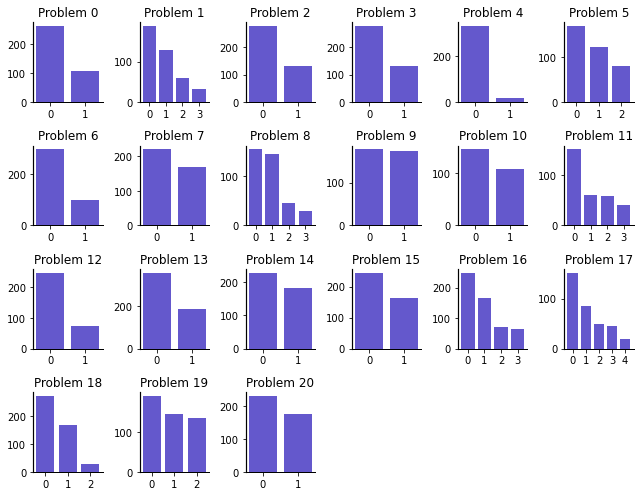

In [181]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(9,7)) 
axes = axes.flatten()

for i in problem_id:
    axes[i].bar(train[train.problem_id==i]['target'].unique(),
                train[train.problem_id==i]['target'].value_counts(),
                color='#6458cc')
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)
    axes[i].title.set_text(f'Problem {i}')
    axes[i].set_xticks(train[train.problem_id==i]['target'].unique()) 
    axes[i].set_xticklabels(train[train.problem_id==i]['target'].unique())
    axes[i].spines['left'].set_linewidth(1.2)
    axes[i].spines['bottom'].set_linewidth(1)
    ax = plt.gca()
    ax.tick_params(width=1.2)
axes.flat[-1].set_visible(False)
axes.flat[-2].set_visible(False)
axes.flat[-3].set_visible(False)
plt.tight_layout() 
#plt.savefig('problem_id_target.png')
plt.show()

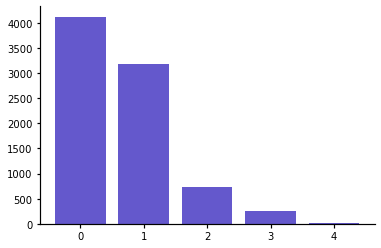

In [178]:
fig, ax = plt.subplots(figsize=(6,4))
ax.bar(train['target'].unique(),
       train['target'].value_counts(),
       color='#6458cc')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.2)
ax.spines['bottom'].set_linewidth(1.2)
ax = plt.gca()
ax.tick_params(width=1.2)
#plt.savefig('target.png')
plt.show()

In [17]:
train['target'].value_counts()

0    4124
1    3175
2     729
3     255
4      19
Name: target, dtype: int64

### Mean Target Encoding

In [327]:
def target_encoding(train, col="problem_id", target="target", splits=5):
    kf = KFold(n_splits=splits, shuffle=False)
    new_col = col + "_" + "mean_enc"
    train[new_col] = np.nan
    global_mean = train[target].mean()
    for train_index, val_index in kf.split(train):
        k_train = train.iloc[train_index]
        k_val = train.iloc[val_index]
        mean_device_type = k_train.groupby(col)[target].mean()
        train.loc[train.index[val_index], new_col] = k_val[col].map(mean_device_type)
        train[new_col].fillna(global_mean, inplace=True)

def mean_encoding_test(test, train, col="problem_id", target="target"):
    new_col = col + "_" + "mean_enc"
    mean_device_type = train.groupby(col)[target].mean()
    global_mean = train[target].mean()
    test[new_col] = test[col].map(mean_device_type)
    test[new_col].fillna(global_mean, inplace=True)

target_encoding(train)
mean_encoding_test(test, train)

### Train test split

In [328]:
y = train['target']
X = train.drop(columns=['target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2
                                                    stratify=X['problem_id'])

## One model per problem id

In [360]:
problem_id = X.problem_id.unique()

### Hyperparameter tuning

In [ ]:
# XGBoost
xgbs = []
for i in problem_id:
    subx = X_train[X_train.problem_id==i]
    suby = y_train[X_train.problem_id==i]
    pipe = make_pipeline(
                        StandardScaler(),
                        XGBClassifier()
                        )

    xgb_hyper = dict(#xgbclassifier__booster=['gbtree', 'gblinear', 'dart'],
                     xgbclassifier__eta=np.arange(0, 1, 0.01),
                     xgbclassifier__gamma=range(0, 10),
                     xgbclassifier__subsample=[0.5,0.6,0.7],
                     xgbclassifier__max_depth=range(2, 15),
                     xgbclassifier__min_child_weight=[0,5,10,15,30,50,100])
                     #xgbclassifier__sampling_method=['uniform', 'gradient_based'])

    clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  param_distributions=xgb_hyper, 
                                  n_iter=25,
                                  cv=5, 
                                  scoring='accuracy',
                                  n_jobs=-2,
                                  verbose=False)

    clf_rand_cv.fit(subx, suby)
    xgbs.append(clf_rand_cv)

In [312]:
# SVC
svcs = []
for i in problem_id:
    subx = X_train[X_train.problem_id==i]
    suby = y_train[X_train.problem_id==i]
    pipe = make_pipeline(
                        StandardScaler(),
                        SVC(),
                        )
    SVC_hyper = dict(svc__C = [0.01, 0.05, 0.1, 0.3, 0.5, 1, 10, 50],
                 svc__kernel = ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
                 svc__gamma = ['scale', 'auto'],
                 svc__degree = range(1,5))

    clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  param_distributions=SVC_hyper, 
                                  n_iter=25,
                                  cv=5, 
                                  scoring='accuracy',
                                  n_jobs=-2,
                                  verbose=False)

    clf_rand_cv.fit(subx, suby)
    svcs.append(clf_rand_cv)

In [314]:
# KNN
knns = []
for i in problem_id:
    subx = X_train[X_train.problem_id==i]
    suby = y_train[X_train.problem_id==i]
    pipe = make_pipeline(
                        StandardScaler(),
                        KNeighborsClassifier(n_jobs=-2),
                        )
    
    knn_hyper = dict(kneighborsclassifier__n_neighbors = range(3,50),
                 kneighborsclassifier__leaf_size = range(2,40),
                 kneighborsclassifier__weights = ['uniform', 'distance'])

    clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  param_distributions=knn_hyper, 
                                  n_iter=25,
                                  cv=5, 
                                  scoring='accuracy',
                                  n_jobs=-2,
                                  verbose=False)

    clf_rand_cv.fit(subx, suby)
    knns.append(clf_rand_cv)


In [310]:
# Logistic regression
lrs = []
for i in problem_id:
    subx = X_train[X_train.problem_id==i]
    suby = y_train[X_train.problem_id==i]
    pipe = make_pipeline(
                        StandardScaler(),
                        LogisticRegression(multi_class='ovr', n_jobs=-2),
                        )
    
    lr_hyper = dict(logisticregression__C = [0.01, 0.05, 0.1, 0.3, 0.5, 1, 10, 50],
                logisticregression__fit_intercept = [True, False],
                logisticregression__class_weight = [None, 'balanced'])

    clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  param_distributions=lr_hyper, 
                                  n_iter=25,
                                  cv=5, 
                                  scoring='accuracy',
                                  n_jobs=-2,
                                  verbose=False)

    clf_rand_cv.fit(subx, suby)
    lrs.append(clf_rand_cv)


In [308]:
# Light GBM
lgbs = []
for i in problem_id:
    subx = X_train[X_train.problem_id==i]
    suby = y_train[X_train.problem_id==i]
    pipe = make_pipeline(
                        LGBMClassifier()
                        )

    lgb_hyper = dict(lgbmclassifier__boosting_type=['gbtree', 'gblinear', 'dart', 'goss'],
                     lgbmclassifier__learning_rate=np.arange(0, 1, 0.05),
                     lgbmclassifier__n_estimators=range(0, 210, 10),
                     lgbmclassifier__subsample=[0.5,0.6,0.7, 0.8],
                     lgbmclassifier__max_depth=range(2, 15),
                     lgbmclassifier__min_child_weight=[0.001, 0.01, 0.1, 0,5,10,15,30,50,100],
                     lgbmclassifier__num_leaves=range(10,80,10)
                     )

    clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                  param_distributions=lgb_hyper, 
                                  n_iter=25,
                                  cv=5, 
                                  scoring='accuracy',
                                  n_jobs=-2,
                                  verbose=False)

    clf_rand_cv.fit(subx, suby)
    lgbs.append(clf_rand_cv)

### XGBoost

In [317]:
y_pred_train = []
for index, row in X_train.iterrows():
    y_pred_train.append(xgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Training accuracy:', accuracy_score(y_train, y_pred_train))

y_pred = []
for index, row in X_test.iterrows():
    y_pred.append(xgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Validation accuracy:', accuracy_score(y_test, y_pred))

Training accuracy: 0.8694473723836772
Validation accuracy: 0.7074051776038531


### SVC

In [313]:
y_pred_train = []
for index, row in X_train.iterrows():
    y_pred_train.append(svcs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Training accuracy:', accuracy_score(y_train, y_pred_train))
y_pred = []
for index, row in X_test.iterrows():
    y_pred.append(svcs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Validation accuracy:', accuracy_score(y_test, y_pred))

Training accuracy: 0.9045324499322391
Validation accuracy: 0.7350993377483444


### KNN

In [315]:
y_pred_train = []
for index, row in X_train.iterrows():
    y_pred_train.append(knns[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Training accuracy:', accuracy_score(y_train, y_pred_train))

y_pred = []
for index, row in X_test.iterrows():
    y_pred.append(knns[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Validation accuracy:', accuracy_score(y_test, y_pred))

Training accuracy: 0.8233699744014455
Validation accuracy: 0.6971703792895846


### Logistic regression

In [311]:
y_pred_train = []
for index, row in X_train.iterrows():
    y_pred_train.append(lrs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Training accuracy:', accuracy_score(y_train, y_pred_train))

y_pred = []
for index, row in X_test.iterrows():
    y_pred.append(lrs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Validation accuracy:', accuracy_score(y_test, y_pred))

Training accuracy: 0.9855443457310646
Validation accuracy: 0.7146297411198074


### Light GBM

In [309]:
y_pred_train = []
for index, row in X_train.iterrows():
    y_pred_train.append(lgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Training accuracy:', accuracy_score(y_train, y_pred_train))

y_pred = []
for index, row in X_test.iterrows():
    y_pred.append(lgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1)))

print('Validation accuracy:', accuracy_score(y_test, y_pred))

Training accuracy: 0.8577021532901672
Validation accuracy: 0.7043949428055388


### Ensemble

In [318]:
y_pred_train = []
for index, row in X_train.iterrows():
    y_pred1 = lgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred2 = lrs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred3 = knns[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred4 = svcs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred5 = xgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred_train.append(mode([y_pred1, y_pred2, y_pred3, y_pred4, y_pred5]))

print('Training accuracy:', accuracy_score(y_train, y_pred_train))

y_pred = []
for index, row in X_test.iterrows():
    y_pred1 = lgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred2 = lrs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred3 = knns[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred4 = svcs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred5 = xgbs[int(row['problem_id'])].predict(np.array(row).reshape(1, -1))[0]
    y_pred.append(mode([y_pred1, y_pred2, y_pred3, y_pred4, y_pred5]))

print('Validation accuracy:', accuracy_score(y_test, y_pred))

Training accuracy: 0.9439843397078753
Validation accuracy: 0.7212522576760987


## One general model

### XGBoost

In [70]:

pipe = make_pipeline(
                    StandardScaler(),
                    XGBClassifier()
                    )

xgb_hyper = dict(xgbclassifier__booster=['gbtree', 'gblinear', 'dart'],
                 xgbclassifier__eta=np.arange(0, 1, 0.05),
                 xgbclassifier__gamma=range(0, 10),
                 xgbclassifier__subsample=[0.5,0.6,0.7],
                 xgbclassifier__max_depth=range(2, 15),
                 xgbclassifier__min_child_weight=[0,5,10,15,30,50,100],
                 xgbclassifier__sampling_method=['uniform', 'gradient_based'])

clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=xgb_hyper, 
                              n_iter=25,
                              cv=5, 
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=False)

clf_rand_cv.fit(X_train, y_train)

# Best hyperparameters
print(clf_rand_cv.best_params_)

[21:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { gamma, max_depth, min_child_weight, sampling_method, subsample } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:01:37] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'xgbclassifier__subsample': 0.5, 'xgbclassifier__sampling_method': 'gradient_based', 'xgbclassifier__min_child_weight': 5, 'xgbclassifier__max_depth': 10, 'xgbclassifier__gamma': 2, 'xgbclassifier__eta': 0.35000000000000003, 'xgbclassifier__booster': 'gblinear'}


In [359]:
pipe = make_pipeline(StandardScaler(),
                     XGBClassifier(max_depth=9,
                                       gamma=2,
                                       eta=0.1,
                                       booster='dart',
                                       sampling_method='uniform',
                                       seed=1))
                                    
                                       
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_train)
print('Training Accuracy:', accuracy_score(y_train, y_pred))

[17:16:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy: 0.9977413040204789


In [24]:
# validation accuracy
y_pred = pipe.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[16:49:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[695 110  18   4   0]
 [172 456  14   0   0]
 [ 57  29  54   0   0]
 [ 24  17   3   4   0]
 [  1   0   0   2   1]]
0.7284768211920529


### Light GMB

In [247]:
pipe = make_pipeline(
                        StandardScaler(),
                        LGBMClassifier(extra_trees=True)
                        )

lgb_hyper = dict(lgbmclassifier__boosting_type=['gbtree', 'gblinear', 'dart', 'goss'],
                 lgbmclassifier__learning_rate=np.arange(0, 1, 0.05),
                 lgbmclassifier__n_estimators=range(0, 210, 10),
                 lgbmclassifier__subsample=[0.5,0.6,0.7, 0.8],
                 lgbmclassifier__max_depth=range(2, 15),
                 lgbmclassifier__min_child_weight=[0.001, 0.01, 0.1, 0,5,10,15,30,50,100],
                 lgbmclassifier__num_leaves=range(10,80,10)
                 )

clf_rand_cv = RandomizedSearchCV(estimator=pipe, 
                              param_distributions=lgb_hyper, 
                              n_iter=25,
                              cv=5, 
                              scoring='accuracy',
                              n_jobs=-1,
                              verbose=False)

clf_rand_cv.fit(X_train, y_train)
print(clf_rand_cv.best_params_)

{'lgbmclassifier__subsample': 0.7, 'lgbmclassifier__num_leaves': 30, 'lgbmclassifier__n_estimators': 10, 'lgbmclassifier__min_child_weight': 30, 'lgbmclassifier__max_depth': 7, 'lgbmclassifier__learning_rate': 0.8, 'lgbmclassifier__boosting_type': 'dart'}


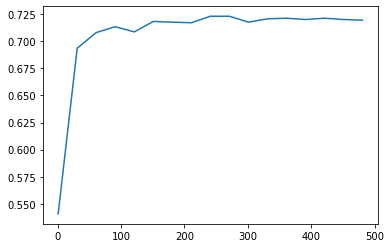

In [319]:
plot_n = []
for n in range(1,500, 30):
    lgb_pipe = make_pipeline(
                         LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=n, num_leaves=60, seed=1))
                                             
    lgb_pipe.fit(X_train, y_train)
    y_pred = lgb_pipe.predict(X_test)
    plot_n.append(accuracy_score(y_test, y_pred))
plt.plot(list(range(1,500, 30)),plot_n)
plt.show()

In [354]:
lgb_pipe = make_pipeline(LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=1))
                                    
                                       
lgb_pipe.fit(X_train, y_train)
y_pred_train = lgb_pipe.predict(X_train)
print('Traininig accuracy:', accuracy_score(y_train, y_pred_train))

y_pred = lgb_pipe.predict(X_test)
print('Validation accuracy:', accuracy_score(y_test, y_pred))

Traininig accuracy: 1.0
Validation accuracy: 0.7429259482239615


### Ensemble

In [355]:
ensemble_lgmb = VotingClassifier([('1', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=1)),
                             ('2', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=2)),
                             ('3', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=3)),
                             ('4', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=4)),
                             ('5', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=6)),
                             ('6', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=7)),
                             ('7', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=77)),
                             ('8', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=777)),
                             ('9', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=66)),
                             ('10', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=521)),
                             ('11', LGBMClassifier(extra_trees=True,subsample=0.5, 
                                        n_estimators=250, num_leaves=60, seed=95))],
                            voting='soft')

ensemble_lgmb.fit(X_train,y_train)

yp = ensemble_lgmb.predict(X_train)
print('Training Accuracy:', accuracy_score(y_train, yp))

yp = ensemble_lgmb.predict(X_test)
print('Validation Accuracy:', accuracy_score(y_test, yp))

Training Accuracy: 1.0
Validation Accuracy: 0.7417218543046358


## Final model

In [357]:
t = test.drop(columns=['target', 'obs_id'])
submission_final = test[['obs_id']]

ensemble_lgmb.fit(X,y)
y_pred = ensemble_lgmb.predict(t)

submission_final.loc[:,'target'] = y_pred
#submission_final.to_csv('submission_final.csv', index=False)

In [358]:
submission_final.target.value_counts()

0    1209
1     732
2      92
3       4
4       4
Name: target, dtype: int64